### A Machine learning approach to identify spurious GPS readings



In [8]:
%run "../common.ipynb"

fileName="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=WITH rows AS (SELECT *,ROW_NUMBER() OVER (ORDER BY mobile_id, id DESC) AS rn FROM loc WHERE (record_type <> 'active' OR record_type IS NULL)) SELECT * FROM rows loc1 WHERE (loc1.rn,loc1.mobile_id)  IN ((SELECT loc2.rn, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn-1, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn%2B1, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn-2, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn%2B2, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn-3, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn%2B3, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) )&type=html";
fileName = fileName.replace(' ', '%20')
dfOriginal = LoadDataSet(fileName, columns=None, checkForDateTime=False);


In [2]:
from datetime import datetime,timedelta
# Prepare dataset
#
# 1. Drop columns we don't need
# 2. Convert column datatypes as needed; to string, datetime, numbers as needed
# 3. Add Calculated Columns
# 4. Filter out rows and reindex the dataframe
# 5. Display the resulting dataframe
# 6. Show some descriptive statistics

#=====
#1. "ProcessedDateId" column is Intentionally misspelled to show it goes undetected if not careful

columns = '''
id, 
stored_at, measured_at, is_valid, api_key, version, record_type, session_num, 
mobile_id, user_id, caller_ip, 
lat, lon, accuracy, speed, bearing, alt, device_temp, device_pressure, device_humidity, device_light, medication, 
weather_time, temperature_min, temperature_max, humidity, no2, pressure, wind, clouds_sky, notes, attr, the_geom, 
location, activity, battery_level, rn"
'''
toDrop= [k.strip() for k in '''id, api_key, version,  session_num, 
mobile_id, 
user_id, 
caller_ip, device_temp, device_pressure, device_humidity, device_light, medication, weather_time, 
temperature_min, temperature_max, humidity, no2, pressure, wind, clouds_sky, notes, attr, 
the_geom,weatherchecked,pef,fev,

'''.split(",")]
dfL = dfOriginal.drop(toDrop, axis=1, errors="ignore")

##1a -> Set the Prediction column
##   -> Set class names if you know it or make it None
predictColumn = "is_valid"
class_names = ["Inalid", "Valid"]

##2. Some wrong dates causing error here - so lets treat this as str
dfL[predictColumn] = dfL[predictColumn].astype(str)    # Treat this columns as string
#dfL[u'ProcessedDateId']   = dfL[u'ProcessedDateId'].astype(str)      # Treat this columns as string (intentionally included)


#Sorted version for mapping
dfL2 = dfL

#DEBUG For printing entire Data Frame
#pd.set_option('display.max_rows', len(dfL['is_valid']))
#print(dfL)
#pd.reset_option('display.max_rows')


##3. Calculated columns
#dfL[u'DBKLag'] = dfL[u'DBKLag']/60                                   # lets divide this by 60 
#dfL[u'DBKLag'] = dfL.DBKLag.apply(abs)                               # Convert to absolute value 

stored_at = []
measured_at = []
is_valid = []
record_type = []
lat = []
lon = []
accuracy = []
speed = []
bearing = []
alt = []
location = []
activity = []
battery_level = []
rn = []

secfromprev = []
sectonext = []
distfromprev = []
disttonext = []
spdfromprev = []
spdtonext = []
angle = []



for k in range(len(dfL[predictColumn])):
    if k == 0 or k == len(dfL[predictColumn])-1:
        continue
    elif dfL['rn'][k]-1 == dfL['rn'][k-1] and dfL['rn'][k]+1 == dfL['rn'][k+1] and dfL['is_valid'][k-1] == '1' and dfL['is_valid'][k+1] == '1':
        
        stored_at.append(dfL['stored_at'][k])
        measured_at.append(dfL['measured_at'][k])
        is_valid.append(dfL['is_valid'][k])
        record_type.append(dfL['record_type'][k])
        lat.append(dfL['lat'][k])
        lon.append(dfL['lon'][k])
        accuracy.append(dfL['accuracy'][k])
        speed.append(dfL['speed'][k])
        bearing.append(dfL['bearing'][k])
        alt.append(dfL['alt'][k])
        location.append(dfL['location'][k])
        activity.append(dfL['activity'][k])
        battery_level.append(dfL['battery_level'][k])
        rn.append(dfL['rn'][k])
        
        curdatetime = datetime.strptime(dfL['measured_at'][k].split('.')[0],'%Y-%m-%d %H:%M:%S')
        prevdatetime = datetime.strptime(dfL['measured_at'][k+1].split('.')[0],'%Y-%m-%d %H:%M:%S')
        nextdatetime = datetime.strptime(dfL['measured_at'][k-1].split('.')[0],'%Y-%m-%d %H:%M:%S')
        
        #seconds from previous
        secfromprev.append((curdatetime - prevdatetime).seconds)
        
        
        #seconds to next
        sectonext.append((nextdatetime-curdatetime).seconds)
        
        
        curlat = dfL['lat'][k]
        curlon = dfL['lon'][k]
        
        
        nextlat = dfL['lat'][k-1]
        nextlon = dfL['lon'][k-1]
        
        prevlat = dfL['lat'][k+1]
        prevlon = dfL['lon'][k+1]
        
        #miles to next
        disttonext.append(math.sqrt(69.1*(curlat-nextlat)*69.1*(curlat-nextlat)+(69.1*(curlon - nextlon)*cos(nextlat/57.3))*(69.1*(curlon - nextlon)*cos(nextlat/57.3))))
        #print(disttonext[k])
        
        #miles from prev
        distfromprev.append(math.sqrt(69.1*(curlat-prevlat)*69.1*(curlat-prevlat)+(69.1*(curlon - prevlon)*cos(prevlat/57.3))*(69.1*(curlon - prevlon)*cos(prevlat/57.3))))
        #print(distfromprev[k])
        
        
        
        #Speed in MPH to next
        if sectonext[len(sectonext)-1] != 0:
            spdtonext.append(disttonext[len(disttonext)-1]/(sectonext[len(sectonext)-1]/3600))
        else:
            spdtonext.append(None)
        #print(spdtonext[k])
        
        #Speed in MPH from prev
        if secfromprev[len(secfromprev)-1] != 0:
            spdfromprev.append(distfromprev[len(distfromprev)-1]/(secfromprev[len(secfromprev)-1]/3600))
        else:
            spdfromprev.append(None)
        #print(spdfromprev[k])
        
        #Angle in degrees between previous point, next point, and current point
        if distfromprev[len(distfromprev)-1]*disttonext[len(disttonext)-1] != 0:
            distancebetweennextandprev = math.sqrt(69.1*(prevlat-nextlat)*69.1*(prevlat-nextlat)+(69.1*(prevlon - nextlon)*cos(nextlat/57.3))*(69.1*(prevlon - nextlon)*cos(nextlat/57.3)))
            lawofcos = (math.pow(distancebetweennextandprev,2) - math.pow(distfromprev[len(distfromprev)-1],2) - math.pow(disttonext[len(disttonext)-1],2))/(-2*distfromprev[len(distfromprev)-1]*disttonext[len(disttonext)-1])
            if lawofcos < -1:
                lawofcos = -1
            if lawofcos > 1:
                lawofcos = 1
            angle.append((180/math.pi)*math.acos(lawofcos))
        else:
            angle.append(None)
        #print(angle[k])
  

newdict = {'stored_at': stored_at,
'measured_at': measured_at,
'is_valid': is_valid,
'record_type': record_type,
'lat': lat,
'lon': lon,
'accuracy': accuracy,
'speed': speed,
'bearing': bearing,
'alt': alt,
'location': location,
'activity': activity,
'battery_level': battery_level,
'rn': rn,
'secfromprev': secfromprev,
'sectonext': sectonext,
'distfromprev': distfromprev,
'disttonext': disttonext,
'spdfromprev': spdfromprev,
'spdtonext': spdtonext,
'angle': angle }

dfLnew = pd.DataFrame(newdict)

#pd.set_option('display.max_rows', len(dfL['is_valid']))
#print(dfLnew)
#pd.reset_option('display.max_rows')

#print(dfL['rn'][dfL['is_valid']=='2'])

dfL = dfLnew
        
##4. Filter rows
n1 = dfL.shape[0]
#dfL = dfL[dfL.DBKLag > 1]                                            # Lets take only those that have a value > 0 
#
## Here are other common filtering you may use:
# dfL = dfL[dfL['OEMModel'] == "Surface Pro 4"]
# dfL = dfL[dfL.OSVersionFull.str.contains("th1") | dfL.OSVersionFull.str.contains("th2")]
# dfL = dfL[dfL.is_valid == '2'-1 | dfL.is_valid == '2' | dfL.is_valid == '2'+1]
#print(dfL[dfL.is_valid == '2'-1 | dfL.is_valid == '2' | dfL.is_valid == '2'+1])
#print(dfL.is_valid[1:] == '2' dfL.is_valid == '2' or dfL.is_valid[:1] == '2')
#pd.set_option('display.max_rows', len(dfL['is_valid']))
#print(dfL)
#pd.reset_option('display.max_rows')

n2 = dfL.shape[0]
print ("Filtering: Number of rows Before {} and After {}".format(n1,n2));

#4a. You may reshuffle the rows if needed to make sure they are not in any particular order
dfL = dfL.sample(frac=1).reset_index(drop=True)

#4b. 
# Once you filter, it is a good idea to reindex such that 0th row matches to 0th row in the resulting dataframe
# To see what happens if you didn't to reindex, comment out the following code and notice index 1 and 3 are visibly missing 

dfL = dfL.reset_index(drop=True) 

#5.
displayDFs(dfL, showIcons=True, showStats=True, maxrows = 4) 

# You can see the entire dataframe by using the following
# HTML(dfL.to_html())

Filtering: Number of rows Before 85 and After 85


count,85.000,85,79.000,73.000,0.000,79.000,85.000,85.000,85,85.000,0.000,85.000,85,85,85.000,85.000,85.000,81.000,76.000,79.000,85
unique,-,1,-,-,0.000,-,-,-,2,-,0.000,-,84,6,-,-,-,-,-,-,85
top,-,null,-,-,-,-,-,-,1,-,-,-,2016-05-24 01:35:44.0,gps,-,-,-,-,-,-,2015-08-25 17:37:54.971956
freq,-,85,-,-,-,-,-,-,58,-,-,-,2,46,-,-,-,-,-,-,1
mean,277.456,-,66.139,40.865,-,36.032,1.039,112.093,-,44.010,-,-74.006,-,-,13115.482,2639.518,1794.447,128.665,102.105,1.179,-
std,494.239,-,286.676,52.548,-,89.722,4.128,1030.327,-,5.909,-,90.255,-,-,5555.446,9649.092,8257.179,731.380,343.979,4.560,-
min,0.000,-,0.000,0.000,-,0.000,0.000,0.000,-,24.195,-,-122.322,-,-,1616.000,0.000,0.000,0.001,0.002,0.000,-
25%,22.107,-,0.000,1.531,-,0.000,0.031,0.028,-,39.563,-,-122.140,-,-,12508.000,38.000,18.000,0.915,1.315,0.000,-
50%,50.000,-,0.000,15.650,-,0.000,0.109,0.067,-,47.630,-,-122.136,-,-,14140.000,61.000,60.000,3.878,4.192,0.000,-
75%,112.000,-,10.500,54.037,-,0.000,0.298,0.214,-,47.645,-,-93.230,-,-,16112.000,381.000,213.000,14.178,27.750,0.000,-
max,2805.000,-,1884.000,179.514,-,357.000,28.999,9499.477,-,47.654,-,127.050,-,-,23733.000,63561.000,62894.000,5219.790,1856.760,28.750,-


### Descriptive Statistics

In [9]:
#Wade can you find a way to plot the points on a map here!

# Given three consecutive readings from a GPS system (p1, p2, p3), is it possible to detect if p2 is invalid?
# or Give a set of points p1 .. pn, detect all invalid readings!

import folium



midlat = mean(dfL2['lat'])
midlon = mean(dfL2['lon'])



dfL2.reset_index(drop=True,inplace=True)

#pd.set_option('display.max_rows', len(dfL2['is_valid']))
#print(dfL2)
#pd.reset_option('display.max_rows')


map1 = folium.Map(location=(47.643, -122.129) , zoom_start=14, width=640, height=500)

for k in range(len(dfL2['is_valid'])):
    if dfL2['is_valid'][k] == '1':
        #Valid Points Blue
        fcolor = '#0000FF'
    else:
        #Invalid Points Red
        fcolor = '#FF0000'
    
    #map1.circle_marker(location=[dfL['lat'][k], dfL['lon'][k]], radius=500, line_color='#000000',fill_color=fcolor)
    folium.CircleMarker([dfL2['lat'][k], dfL2['lon'][k]],
                    radius=7,
                    color=fcolor,
                    fill_color=fcolor,
                   ).add_to(map1)
    if k != len(dfL2[predictColumn])-1 and dfL2['rn'][k]+1 == dfL2['rn'][k+1]:
        map1.line([[dfL2['lat'][k],dfL2['lon'][k]],[dfL2['lat'][k+1],dfL2['lon'][k+1]]], line_color='#000000', line_weight=1)
        
display(map1)  


d:\student data\documents\anaconda\anaconda\lib\site-packages\ipykernel\__main__.py:39: FutureWarning: line is deprecated. Use add_children(PolyLine) instead


Dropping in prepareDF -  Index(['measured_at', 'stored_at'], dtype='object')


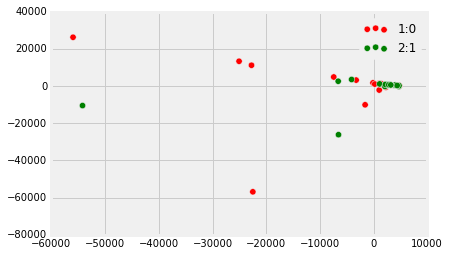

In [4]:
dfPCA=PCAPlot(dfL, predictColumn)

## Predictions

In [5]:
# Lets convert the columns to numeric 
# Please see Prepare in Features.py 

df =  prepareDF(dfL, makeCopy=True)

# Review the resulting final data set;
#df = df.sample(frac=1).reset_index(drop=True)
display(dfL.head(), "==>" ,df.head() )

Dropping in prepareDF -  Index(['measured_at', 'stored_at'], dtype='object')


,accuracy,activity,alt,angle,battery_level,bearing,distfromprev,disttonext,is_valid,lat,location,lon,measured_at,record_type,rn,secfromprev,sectonext,spdfromprev,spdtonext,speed,stored_at
0,49.000,null,123.000,5.159,None,319.000,0.040,0.056,1,47.645,None,-122.137,2016-04-11 20:43:06.0,passive,14142,38,16,3.809,12.530,0.750,2016-04-12 00:40:39.983809
1,2805.000,null,0.000,0.000,None,0.000,0.692,0.692,2,44.871,None,-91.926,2016-04-06 00:28:05.0,passive,8043,298,37,8.356,67.299,0.000,2016-04-06 03:02:06.221749
2,22.278,null,0.000,133.072,None,0.000,0.060,0.037,1,47.645,None,-122.136,2016-03-29 20:02:26.0,gps,16000,45,87,4.799,1.520,0.000,2016-03-29 21:22:50.634986
3,0.000,null,nan,7.798,None,nan,3.255,2.089,1,44.841,None,-93.644,2015-08-25 17:41:23.0,SyntheticData,23729,79,10,148.319,752.036,nan,2015-08-25 17:35:37.901258
4,0.000,null,nan,0.000,None,nan,23.601,9499.477,2,45.025,None,-93.197,2016-01-31 06:41:38.0,SyntheticData,23704,46663,32582,1.821,1049.602,nan,2016-01-31 06:41:42.036251


'==>'

,accuracy,activity,alt,angle,battery_level,bearing,distfromprev,disttonext,is_valid,lat,location,lon,record_type,rn,secfromprev,sectonext,spdfromprev,spdtonext,speed
0,49.000,0,123.000,5.159,0,319.000,0.040,0.056,0,47.645,0,-122.137,5,14142,38,16,3.809,12.530,0.750
1,2805.000,0,0.000,0.000,0,0.000,0.692,0.692,1,44.871,0,-91.926,5,8043,298,37,8.356,67.299,0.000
2,22.278,0,0.000,133.072,0,0.000,0.060,0.037,0,47.645,0,-122.136,3,16000,45,87,4.799,1.520,0.000
3,0.000,0,0.000,7.798,0,0.000,3.255,2.089,0,44.841,0,-93.644,2,23729,79,10,148.319,752.036,0.000
4,0.000,0,0.000,0.000,0,0.000,23.601,9499.477,1,45.025,0,-93.197,2,23704,46663,32582,1.821,1049.602,0.000


Feature space holds 85 observations and 18 features
Unique target labels: [0 1]
* 0* 1* 2* 3* 4*
   DecisionTree Gini accuracy: 0.694118 
* 0* 1* 2* 3* 4*
   DecisionTree Entr accuracy: 0.682353 
* 0* 1* 2* 3* 4*
                 SVM accuracy: 0.647059 
* 0* 1* 2* 3* 4*
                K-NN accuracy: 0.670588 
* 0* 1* 2* 3* 4*
   Gradient Boosting accuracy: 0.670588 
* 0* 1* 2* 3* 4*
    Logit Regression accuracy: 0.647059 


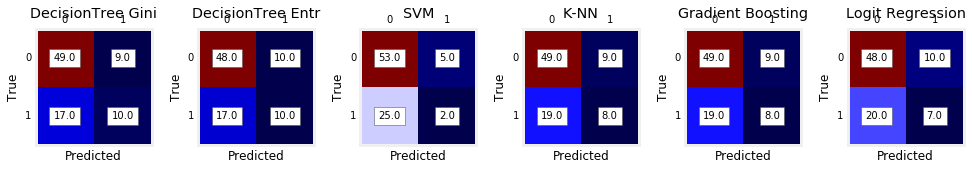

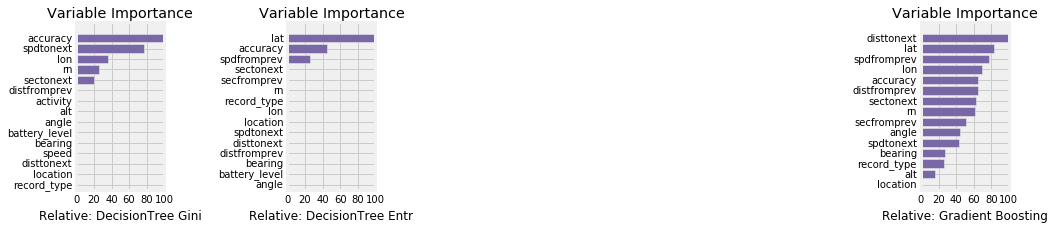

Wall time: 1.77 s


In [10]:
%%time
cls = [# Comment/uncomment out any classfiers according to your need 
       # DO NOT CHANGE
        "DecisionTree Gini" , tree.DecisionTreeClassifier(max_depth=4, criterion="gini"),
        "DecisionTree Entr" , tree.DecisionTreeClassifier(max_depth=4, criterion="entropy"), 
        "SVM"               , sklearn.svm.SVC(), 
        #"Random Forest"     , sklearn.ensemble.RandomForestClassifier(),
        "K-NN"              , sklearn.neighbors.KNeighborsClassifier(),
        "Gradient Boosting" , sklearn.ensemble.RandomForestClassifier(),
        "Logit Regression"  , sklearn.linear_model.LogisticRegression()
];

y = df[predictColumn]
X = df.drop(predictColumn, axis=1)
(X1,y1,ra,cls) = Classify(X,y, True, drawConfusionMatrix=True, classifiers=cls, scale=True)


In [7]:
#get_ipython().reset()
decisionTrees = []

for k in range( int (len(cls)/2)) :
    d = cls[k*2+1];
    if (str(type(d)).find('DecisionTreeClassifier') > 0):
        decisionTrees.append(cls[k*2])
        decisionTrees.append(cls[k*2+1])

#d = DrawDecisionTree(X,y, decisionTrees, class_names);

In [ ]:
#
# Now we need to get the 
# Given three points, distance, angle, time difference, number of time that loc was marked invalid
#

1
2 lat-lon
1
==>
2 speed (1-2); time1 -2 , distance 1-2, angle 1-2-1, # of times 2 is Invalid 

1
1 speed (1-1); time1 -1 , distance 1-1, angle 1-1-1, # of times 1 was read
1
